In [5]:
#Data Processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Deep Learning
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

#Image Processing
import os
from pathlib import Path
import joblib
import time

#Machine Learning
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

#Settings
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

#Set Random seeds
np.random.seed(42)
torch.manual_seed(42)

In [6]:
#Configuration

USE_SUBSET = True
SUBSET_SIZE = 2000
BATCH_SIZE = 32

In [7]:
image_dir = Path('myntradataset/images')

image_paths = list[Path](image_dir.glob('*.jpg'))

fashion_data = []

for img_path in image_paths:
    fashion_data.append({
        'image_id':img_path.stem,
        'image_path':str(img_path),
        'filename': img_path.name
    })

fashion_df = pd.DataFrame(fashion_data)

fashion_df = fashion_df.sample(SUBSET_SIZE, random_state=42).reset_index(drop=True)

fashion_df.head()

,image_id,image_path,filename
0,14087,myntradataset\images\14087.jpg,14087.jpg
1,10790,myntradataset\images\10790.jpg,10790.jpg
2,17055,myntradataset\images\17055.jpg,17055.jpg
3,16206,myntradataset\images\16206.jpg,16206.jpg
4,11845,myntradataset\images\11845.jpg,11845.jpg


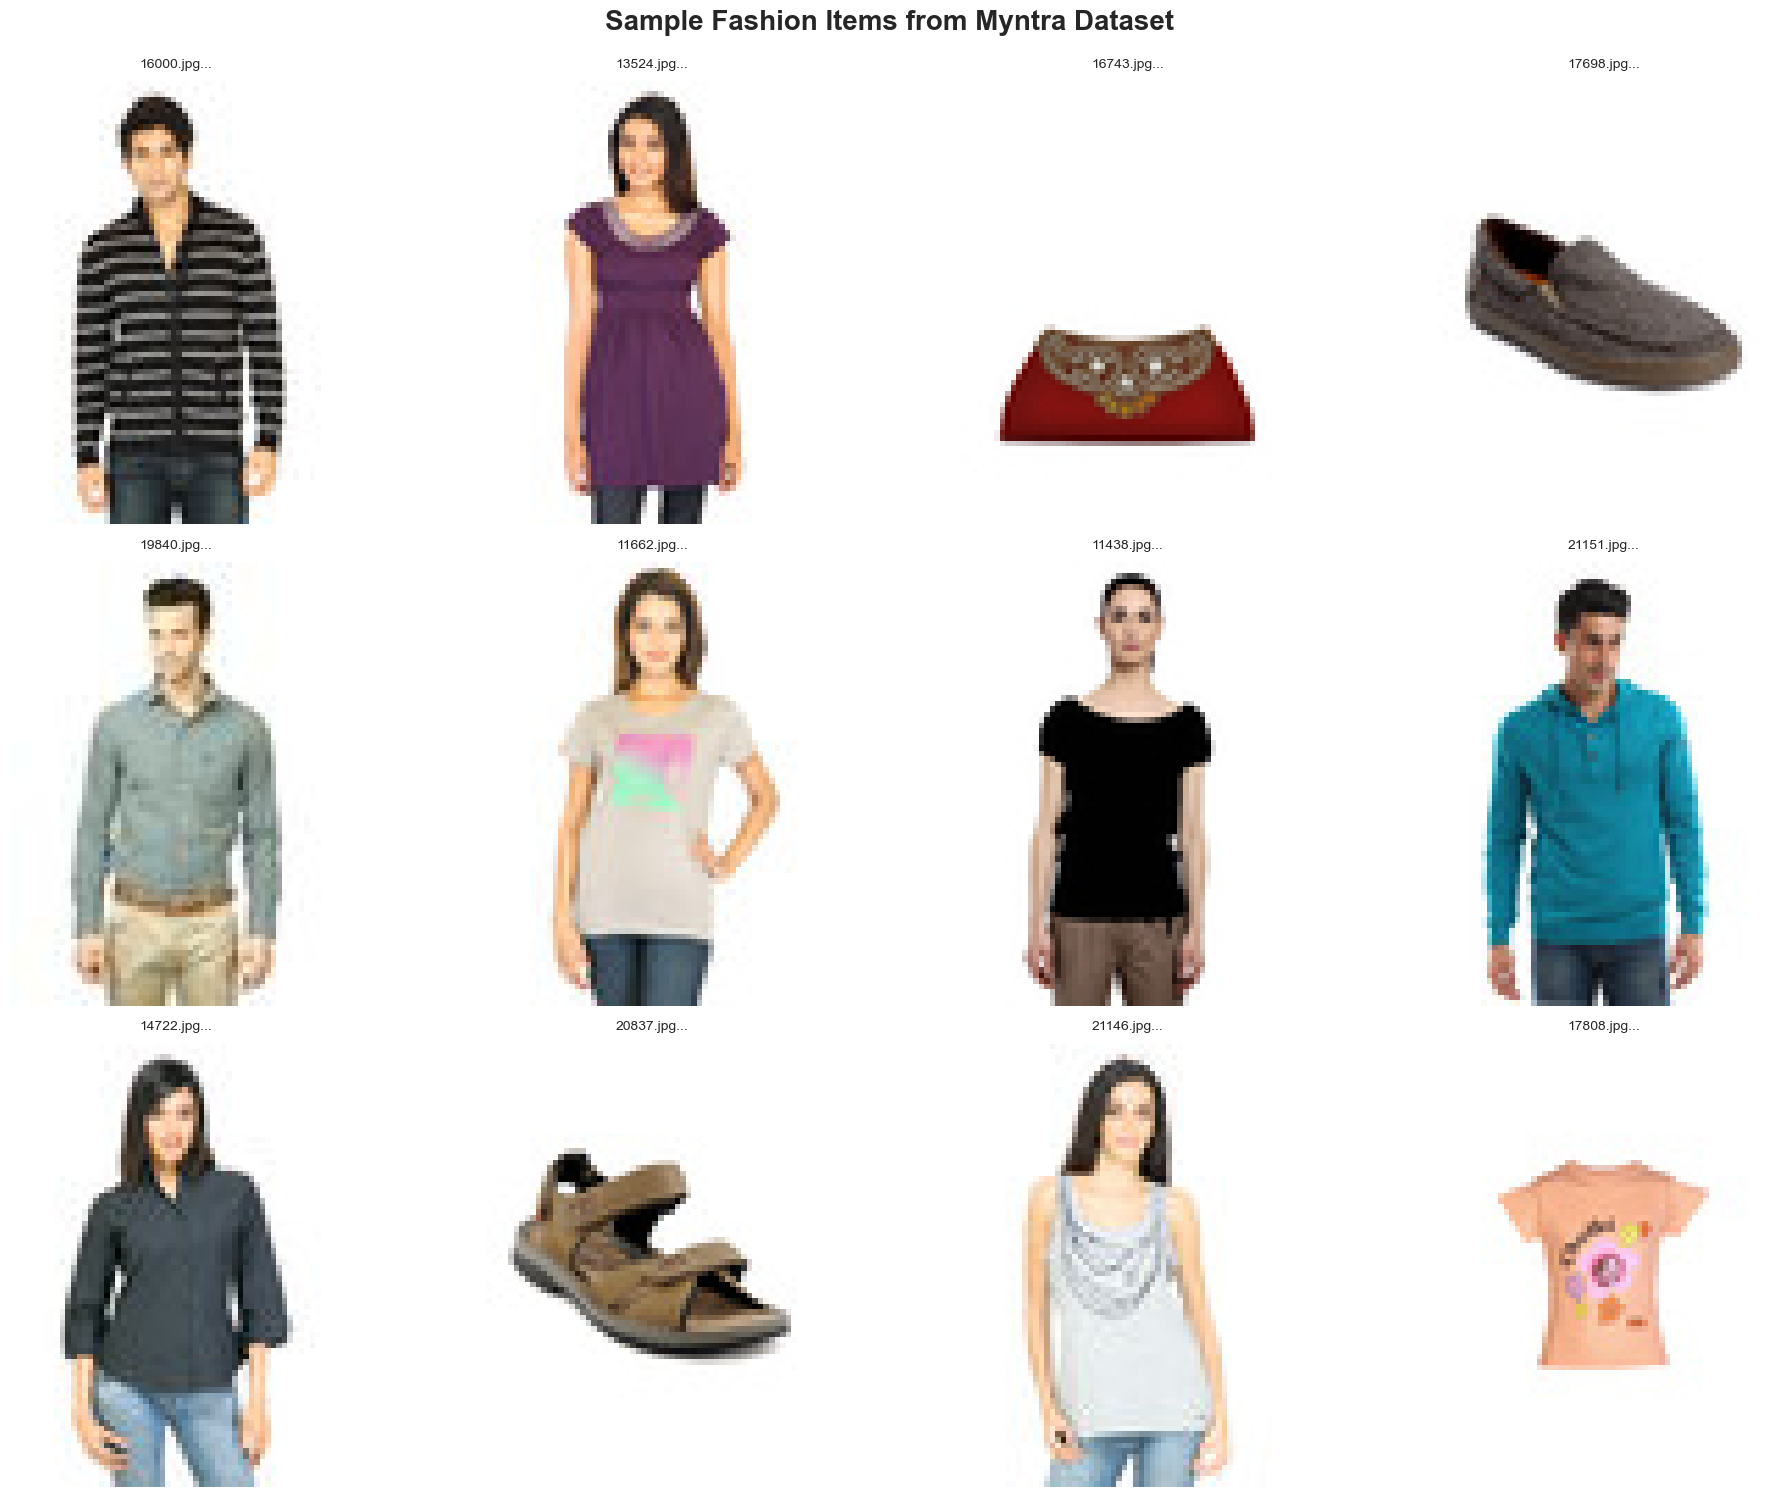

In [8]:
#Display sample images

fig, axes = plt.subplots(3,4, figsize=(20,15))
fig.suptitle('Sample Fashion Items from Myntra Dataset', fontsize=20, fontweight='bold', y=0.995)

sample_items = fashion_df.sample(min(12, len(fashion_df)))

for idx, (ax,(_, item)) in enumerate(zip(axes.flat, sample_items.iterrows())):
    try:
        img = Image.open(item['image_path'])
        ax.imshow(img)
        ax.set_title(f"{item['filename'][:25]}...", fontsize=10, pad =10)
        ax.axis('off')
    except Exception as e:
        ax.text(0.5, 0.5, f'Error loading{item["filename"][:20]}',
                ha='center', va='center', fontsize=9)
        ax.axis('off')
plt.tight_layout()
plt.show()


In [9]:
model = models.resnet18(pretrained=True)

model = nn.Sequential(*list(model.children())[:-1])
model = model.to('cpu')
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]

    )
])

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\surya omar/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:15<00:00, 3.01MB/s]


In [10]:
all_features = []
failed_images = []
start_time = time.time()

for i in range(0, len(fashion_df), BATCH_SIZE):
    batch_df = fashion_df.iloc[i:i+BATCH_SIZE]
    batch_images = []
    batch_indices = []

    for idx, row in batch_df.iterrows():
        try:
            img = Image.open(row['image_path']).convert('RGB')
            img_tensor = transform(img)
            batch_images.append(img_tensor)
            batch_indices.append(idx)
        except Exception as e:
            failed_images.append(row['filename'])
            continue
    if batch_images:
        batch_tensor = torch.stack(batch_images).to('cpu')

        with torch.no_grad():
            features = model(batch_tensor)
            features = features.squeeze().cpu().numpy()

            if len(features.shape) == 1:
                features = features.reshape(1, -1)
            all_features.extend(features)

    if (i + BATCH_SIZE) % 200 == 0 or (i + BATCH_SIZE) >= len(fashion_df):
        elapsed = time.time() - start_time
        progress = min((i + BATCH_SIZE) / len(fashion_df) * 100, 100)
        print(f"Progress: {progress:.1f}% | Processed:{len(all_features):,}/{len(fashion_df):,} | Time : {elapsed:.1f}s")

features_array = np.array(all_features)

if failed_images:
    fashion_df = fashion_df[~fashion_df['filename'].isin(failed_images)].reset_index(drop=True)

elapsed_time = time.time() - start_time



Progress: 40.0% | Processed:800/2,000 | Time : 55.8s
Progress: 80.0% | Processed:1,600/2,000 | Time : 112.3s
Progress: 100.0% | Processed:2,000/2,000 | Time : 145.7s


In [11]:
#Build K-Nearest Neighbors model

knn_model = NearestNeighbors(
    n_neighbors=min(20, len(features_array)),
    metric='cosine',
    algorithm='brute'
)

knn_model.fit(features_array)



NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [12]:
n_test = min(3, len(fashion_df))

for test_num in range(n_test):
    test_idx = np.random.randint(0, len(fashion_df))
    query_item = fashion_df.iloc[test_idx]

    query_features = features_array[test_idx].reshape(1,-1)
    distances, indices = knn_model.kneighbors(query_features, n_neighbors=7)

    indices = indices[0][1:]
    distances = distances[0][1:]

    recommendations = fashion_df.iloc[indices].copy()
    recommendations['similarity'] = 1 - distances

    print("Top Recommendations")
    for i, (_, rec) in enumerate(recommendations.iterrows(),1):
        print(f" {i}. {rec['filename'][:35]:35} |Similarity: {rec['similarity']:2%}")
    print()

Top Recommendations
 1. 11820.jpg                           |Similarity: 90.812647%
 2. 14552.jpg                           |Similarity: 90.673965%
 3. 16976.jpg                           |Similarity: 89.545459%
 4. 20896.jpg                           |Similarity: 89.022475%
 5. 11823.jpg                           |Similarity: 89.018929%
 6. 19053.jpg                           |Similarity: 88.749158%

Top Recommendations
 1. 20454.jpg                           |Similarity: 86.427629%
 2. 20470.jpg                           |Similarity: 85.471857%
 3. 20067.jpg                           |Similarity: 83.662003%
 4. 18806.jpg                           |Similarity: 83.520925%
 5. 18009.jpg                           |Similarity: 80.100161%
 6. 13641.jpg                           |Similarity: 79.745102%

Top Recommendations
 1. 17762.jpg                           |Similarity: 93.643695%
 2. 16155.jpg                           |Similarity: 93.006098%
 3. 12877.jpg                           |S

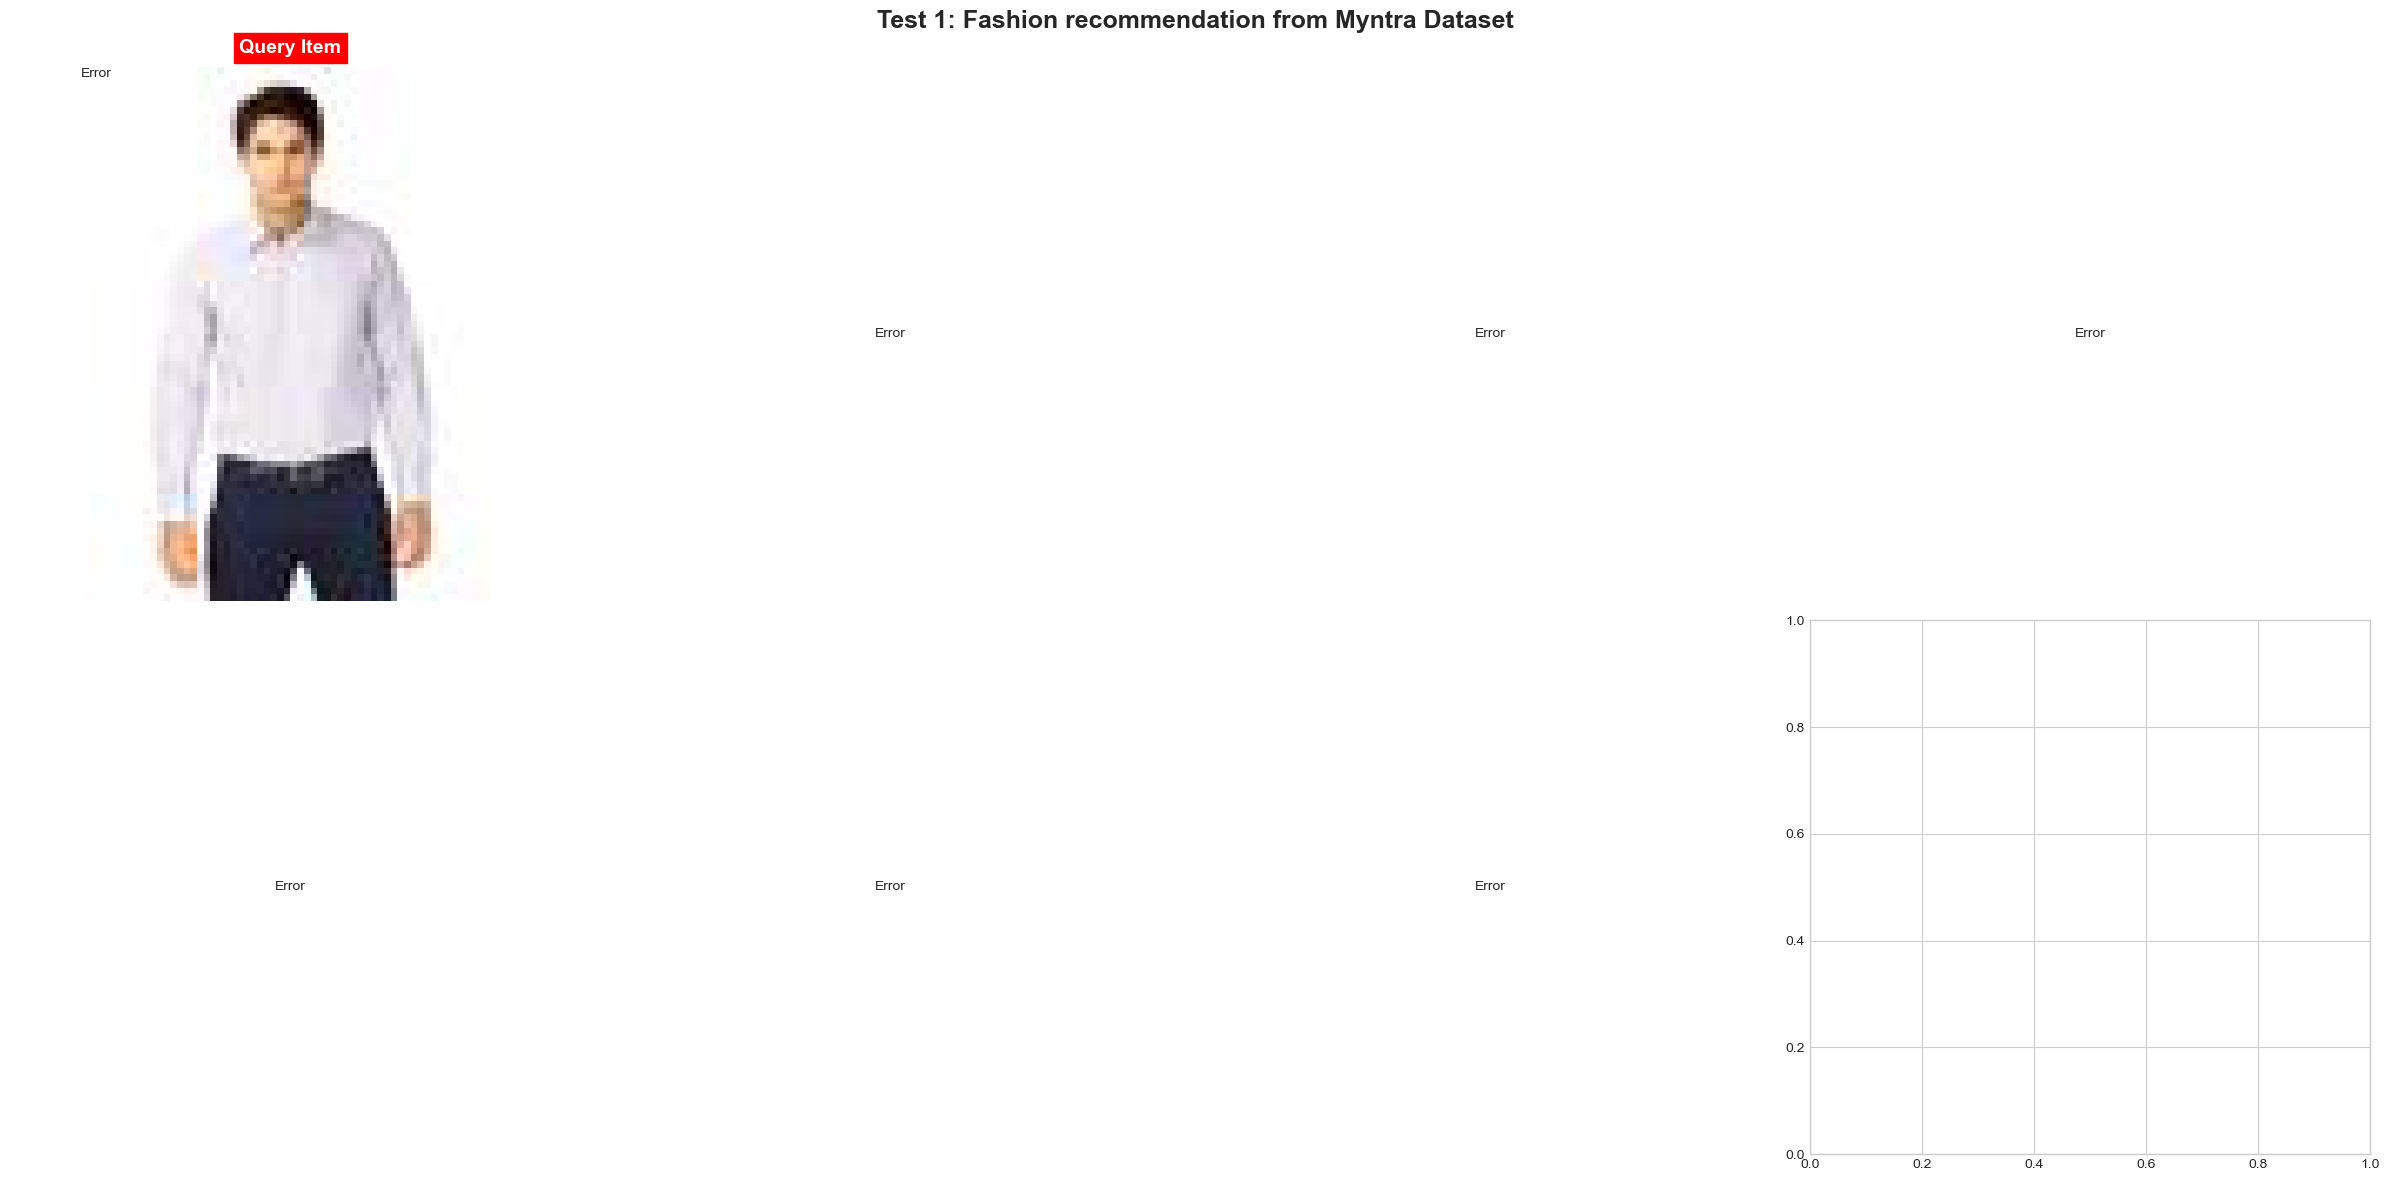

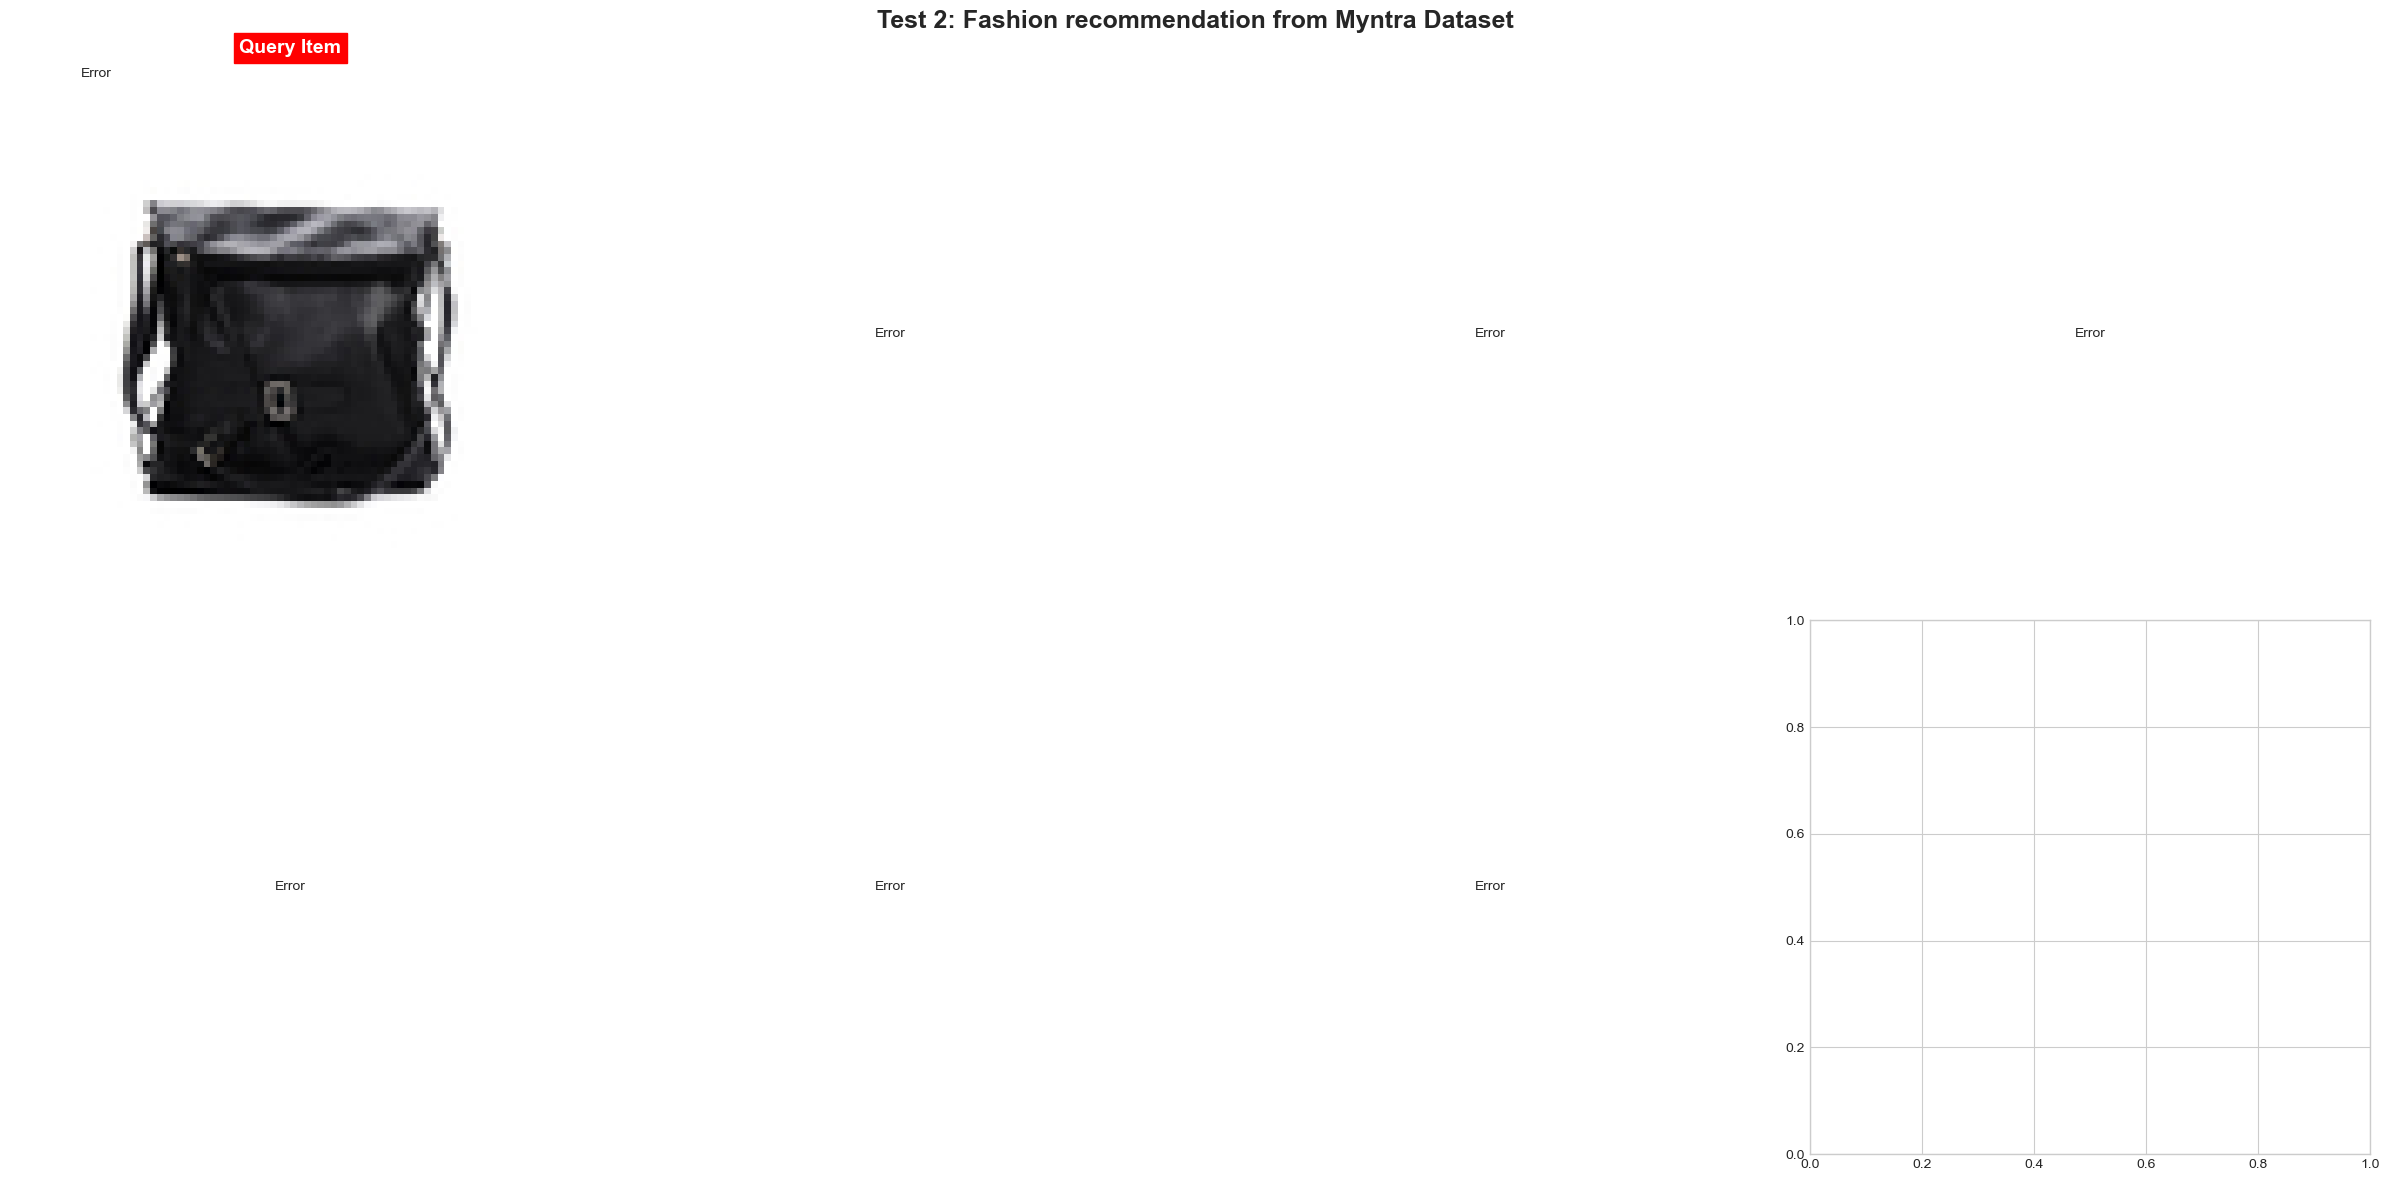

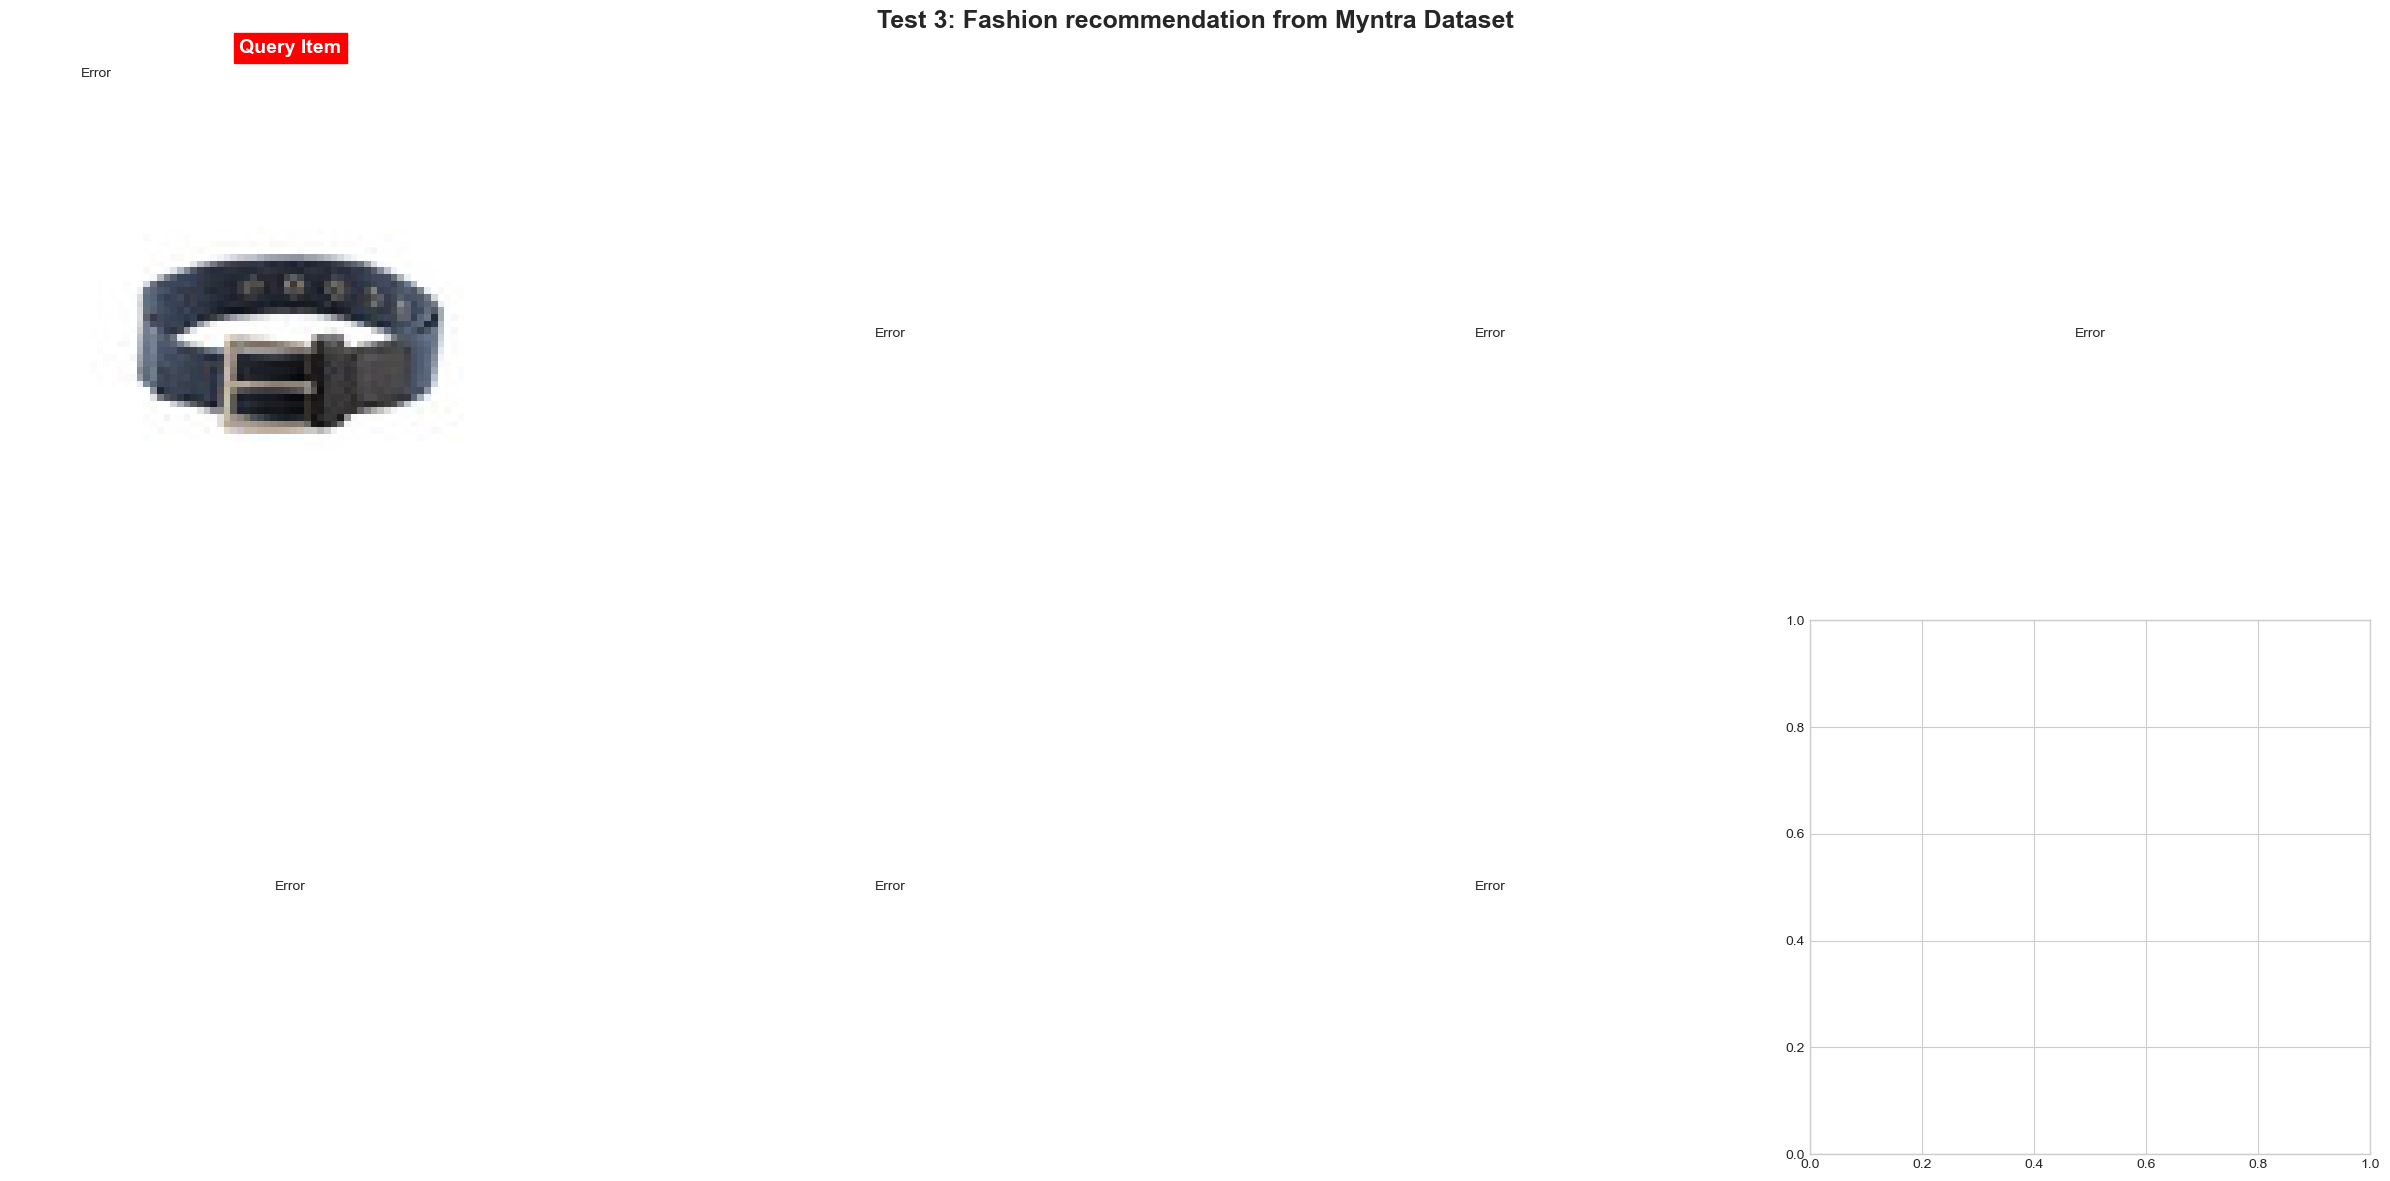

In [13]:
n_test = min(3, len(fashion_df))

for test_num in range(n_test):
    test_idx = np.random.randint(0, len(fashion_df))
    query_item = fashion_df.iloc[test_idx]

    query_features = features_array[test_idx].reshape(1,-1)
    distances, indices = knn_model.kneighbors(query_features, n_neighbors=7)

    indices = indices[0][1:]
    distances = distances[0][1:]

    recommendations = fashion_df.iloc[indices].copy()
    recommendations['similarity'] = 1 - distances

    fig, axes = plt.subplots(2,4, figsize=(24,12))
    fig.suptitle(f"Test {test_num + 1}: Fashion recommendation from Myntra Dataset", fontsize=18, fontweight='bold')

    try:
        query_img = Image.open(query_item['image_path'])
        axes[0,0].imshow(query_img)
        axes[0,0].set_title('Query Item', fontweight='bold',fontsize=14,
                            color='white', backgroundcolor='red', pad=10)
        axes=[0,0].axis('off')
    except:
        axes[0,0].text(0.5,0.5, "Error", ha='center', va='center')
        axes[0,0].axis('off')
    
    for idx, (ax, (_, rec)) in enumerate(zip(axes.flat[1:], recommendations.iterrows())):
        if idx < 7:
            try:
                rec_img = Image.open(rec['image_path'])
                axes.imshow(rec_img)
                ax.set_title(f"Match: {rec['similarity']:.1%}",
                            fontsize=12, fontweight='bold', color='green')
                ax.axis('off')
            except:
                ax.text(0.5, 0.5, "Error", ha='center', va='center')
                ax.axis('off')
    plt.tight_layout()
    plt.show()